# FastSAM

In [42]:

import cv2
import torch

# Define an inference source
source = "/home/clement/projects/analyse_images/grains/images/grains_2.jpg"

# Create a FastSAM model
# from ultralytics import FastSAM
# model = FastSAM("/home/clement/projects/analyse_images/FastSAM/weights/FastSAM-x.pt")  # or FastSAM-x.pt
from ultralytics import SAM
model = SAM("/home/clement/projects/analyse_images/FastSAM/weights/sam_l.pt")  # or FastSAM-x.pt

# Multiple args
from ultralytics.models.sam import Predictor as SAMPredictor

# Create SAMPredictor
overrides = dict(
    conf=0.25, task="segment", 
    mode="predict", imgsz=1024,
    model="/home/clement/projects/analyse_images/FastSAM/weights/sam_b.pt"
    )
predictor = SAMPredictor(overrides=overrides)


100%|██████████| 1.16G/1.16G [01:06<00:00, 18.7MB/s]


In [40]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch


def mask_center(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX,cY)

def format_results(result, filter=0):
    annotations = []
    n = len(result.masks.data)
    for i in range(n):
        annotation = {}
        mask = result.masks.data[i] == 1.0
        if torch.sum(mask) < filter:
            continue
        annotation['id'] = i
        annotation['segmentation'] = mask.cpu().numpy()
        annotation['bbox'] = result.boxes.data[i]
        annotation['score'] = result.boxes.conf[i]
        annotation['area'] = annotation['segmentation'].sum()
        annotations.append(annotation)
    return annotations



def filter_masks(annotations):  # filte the overlap mask
        annotations.sort(key=lambda x: x['area'], reverse=True)
        to_remove = set()
        for i in range(0, len(annotations)):
            a = annotations[i]
            for j in range(i + 1, len(annotations)):
                b = annotations[j]
                if i != j and j not in to_remove:
                    # check if
                    if b['area'] < a['area']:
                        if (a['segmentation'] & b['segmentation']).sum() / b['segmentation'].sum() > 0.8:
                            to_remove.add(j)

        return [a for i, a in enumerate(annotations) if i not in to_remove], to_remove


def fast_show_mask(
        annotation,
        ax,
        random_color=False,
        bboxes=None,
        points=None,
        pointlabel=None,
        retinamask=True,
        target_height=960,
        target_width=960):
    msak_sum = annotation.shape[0]
    height = annotation.shape[1]
    weight = annotation.shape[2]
    #Sort annotations based on area.
    areas = np.sum(annotation, axis=(1, 2))
    sorted_indices = np.argsort(areas)
    annotation = annotation[sorted_indices]
    index = (annotation != 0).argmax(axis=0)
    if random_color:
        color = np.random.random((msak_sum, 1, 1, 3))
    else:
        color = np.ones((msak_sum, 1, 1, 3)) * np.array([30 / 255, 144 / 255, 255 / 255])
    transparency = np.ones((msak_sum, 1, 1, 1)) * 0.6
    visual = np.concatenate([color, transparency], axis=-1)
    mask_image = np.expand_dims(annotation, -1) * visual
    show = np.zeros((height, weight, 4))
    h_indices, w_indices = np.meshgrid(np.arange(height), np.arange(weight), indexing='ij')
    indices = (index[h_indices, w_indices], h_indices, w_indices, slice(None))
    # Use vectorized indexing to update the values of 'show'.
    show[h_indices, w_indices, :] = mask_image[indices]
    if bboxes is not None:
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='b', linewidth=1))
    # draw point
    if points is not None:
        plt.scatter(
            [point[0] for i, point in enumerate(points) if pointlabel[i] == 1],
            [point[1] for i, point in enumerate(points) if pointlabel[i] == 1],
            s=20,
            c='y'
        )
        plt.scatter(
            [point[0] for i, point in enumerate(points) if pointlabel[i] == 0],
            [point[1] for i, point in enumerate(points) if pointlabel[i] == 0],
            s=20,
            c='m'
        )
    if not retinamask:
        show = cv2.resize(show, (target_width, target_height), interpolation=cv2.INTER_NEAREST)
    ax.imshow(show)

def plot_to_result(
            img,
             annotations,
             bboxes=None,
             points=None,
             point_label=None,
             mask_random_color=True,
             better_quality=True,
             retina=False,
             withContours=True) -> np.ndarray:
        if isinstance(annotations[0], dict):
            annotations = [annotation['segmentation'] for annotation in annotations]
        image = img
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_h = image.shape[0]
        original_w = image.shape[1]
        if sys.platform == "darwin":
            plt.switch_backend("TkAgg")
        plt.figure(figsize=(original_w / 100, original_h / 100))
        # Add subplot with no margin.
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0, 0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())

        plt.imshow(image)
        if better_quality:
            if isinstance(annotations[0], torch.Tensor):
                annotations = np.array(annotations.cpu())
            for i, mask in enumerate(annotations):
                mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
                # Write number in center
                center = mask_center(mask)
                cv2.putText(mask, text=str(i), org=center, fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1, color=(0, 0, 0),thickness = 10)
                
                # Write mask
                cv2.imwrite(f"/home/clement/projects/analyse_images/grains/out_test/{i}.jpg", mask*255)
                annotations[i] = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((8, 8), np.uint8))
        # if self.device == 'cpu':
        annotations = np.array(annotations)
        fast_show_mask(
            annotations,
            plt.gca(),
            random_color=mask_random_color,
            bboxes=bboxes,
            points=points,
            pointlabel=point_label,
            retinamask=retina,
            target_height=original_h,
            target_width=original_w,
        )
        # else:
        #     if isinstance(annotations[0], np.ndarray):
        #         annotations = torch.from_numpy(annotations)
        #     self.fast_show_mask_gpu(
        #         annotations,
        #         plt.gca(),
        #         random_color=mask_random_color,
        #         bboxes=bboxes,
        #         points=points,
        #         pointlabel=point_label,
        #         retinamask=retina,
        #         target_height=original_h,
        #         target_width=original_w,
        #     )
        if isinstance(annotations, torch.Tensor):
            annotations = annotations.cpu().numpy()
        if withContours:
            contour_all = []
            temp = np.zeros((original_h, original_w, 1))
            for i, mask in enumerate(annotations):
                if type(mask) == dict:
                    mask = mask['segmentation']
                annotation = mask.astype(np.uint8)
                if not retina:
                    annotation = cv2.resize(
                        annotation,
                        (original_w, original_h),
                        interpolation=cv2.INTER_NEAREST,
                    )
                contours, hierarchy = cv2.findContours(annotation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:

                    contour_all.append(contour)
            cv2.drawContours(temp, contour_all, -1, (255, 255, 255), 2)
            color = np.array([0 / 255, 0 / 255, 255 / 255, 0.8])
            contour_mask = temp / 255 * color.reshape(1, 1, -1)
            plt.imshow(contour_mask)

        plt.axis('off')
        fig = plt.gcf()
        plt.draw()

        try:
            buf = fig.canvas.tostring_rgb()
        except AttributeError:
            fig.canvas.draw()
            buf = fig.canvas.tostring_rgb()
        cols, rows = fig.canvas.get_width_height()
        img_array = np.frombuffer(buf, dtype=np.uint8).reshape(rows, cols, 3)
        result = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
        plt.close()
        return result




def plot(img,
             annotations,
             output_path,
             bboxes=None,
             points=None,
             point_label=None,
             mask_random_color=True,
             better_quality=True,
             retina=False,
             withContours=True):
        if len(annotations) == 0:
            return None
        result = plot_to_result(
            img,
            annotations, 
            bboxes, 
            points, 
            point_label, 
            mask_random_color,
            better_quality, 
            retina, 
            withContours)

        path = os.path.dirname(os.path.abspath(output_path))
        if not os.path.exists(path):
            os.makedirs(path)
        result = result[:, :, ::-1]
        # plt.imshow(result)
        cv2.imwrite(output_path, result)

In [43]:
# everything_results = model(source, device="cpu", retina_masks=True, imgsz=1024, conf=0.4, iou=0.9)
everything_results = model(source, device="cpu")


image 1/1 /home/clement/projects/analyse_images/grains/images/grains_2.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 212635.3ms
Speed: 6.1ms preprocess, 212635.3ms inference, 128.8ms postprocess per image at shape (1, 3, 1024, 1024)


In [44]:
image = everything_results[0].orig_img
annotations = format_results(result=everything_results[0])
annotations_filt = filter_masks(annotations=annotations)

In [45]:
len(annotations_filt[0])

25

In [46]:
plot(annotations=annotations, img=image, output_path="/home/clement/projects/analyse_images/grains/out_test/test2.jpg")

/tmp/ipykernel_11972/2423383760.py:199: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  buf = fig.canvas.tostring_rgb()


In [91]:
masks = [i.masks for i in everything_results[0]]

print(len(masks))

m = masks[0].data.numpy()

print(len(m[0]))
cv2.imwrite("/home/clement/projects/analyse_images/grains/out_test/test.jpg", m[0]*255)


43
1302


True

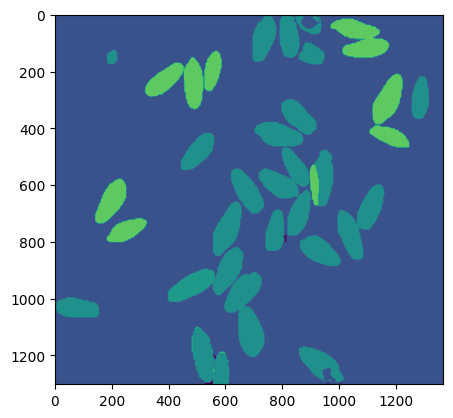

In [102]:
import matplotlib.pyplot as plt
plt.imshow(m[0]*255)

mx = m[0]*255
cv2.putText(mx, text="1", org=(800,800) , fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1, color=(255, 255, 255),thickness = 5)
plt.imshow(mx)

TypeError: Invalid shape (1, 1302, 1369) for image data

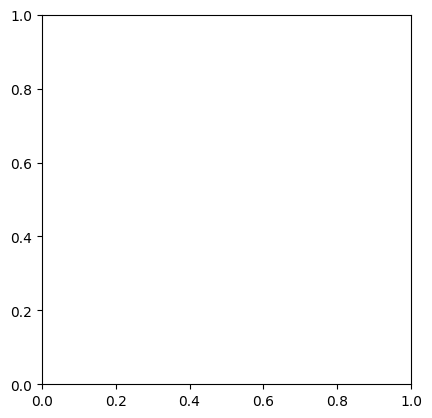

In [120]:
# import numpy as np

m0 = masks[0].data.numpy()

for i in masks:
    m0 += i.data.numpy()

mx = m0[0]*255
# mask_center(mx)
plt.imshow(mx)


In [119]:
masks[0]

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [15., 15., 15.,  ..., 15., 15., 15.],
         [15., 15., 15.,  ..., 15., 15., 15.],
         [15., 15., 15.,  ..., 15., 15., 15.]]])
orig_shape: (1302, 1369)
shape: torch.Size([1, 1302, 1369])
xy: [array([[        262,           0],
       [        262,           2],
       [        261,           3],
       [        251,           3],
       [        250,           4],
       [        186,           4],
       [        185,           5],
       [        184,           5],
       [        183,           4],
       [        153,           4],
       [        152,           5],
       [        147,           5],
       [        146,           4],
       [         79,           4],
       [         78,           5],
       [          0,           5],
       [     

# SAM

In [7]:
from ultralytics import SAM
mod = SAM("/home/clement/projects/analyse_images/FastSAM/weights/sam_l.pt")

In [8]:
from ultralytics.models.sam.predict import Predictor
predictor = Predictor()
predictor.setup_model(mod)
predictor.set_image("/home/clement/projects/analyse_images/grains/images/grains_2.jpg")

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA RTX A1000 Laptop GPU, 3904MiB)
New https://pypi.org/project/ultralytics/8.3.9 available 😃 Update with 'pip install -U ultralytics'


NotImplementedError: WARNING ⚠️ 'SAM' model does not support 'train' mode for 'segment' task yet.

# SAM2

In [3]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor



In [5]:

sam2_checkpoint = "/home/clement/projects/analyse_images/grains/sam2.1_hiera_tiny.pt"
# model_cfg = "/home/clement/projects/analyse_images/grains/sam2.1_hiera_t.yaml"


sam2_model = build_sam2(sam2_checkpoint, device="cpu")

predictor = SAM2ImagePredictor(sam2_model)

with torch.inference_mode(), torch.autocast("cpu", dtype=torch.bfloat16):
    predictor.set_image("home/clement/projects/analyse_images/grains/images/grains_2.jpg")
    masks, _, _ = predictor.predict()

MissingConfigException: Cannot find primary config 'home/clement/projects/analyse_images/grains/sam2.1_hiera_tiny.pt'. Check that it's in your config search path.

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=pkg://sam2_configs
	provider=schema, path=structured://

# FROM SAM GitHub
 

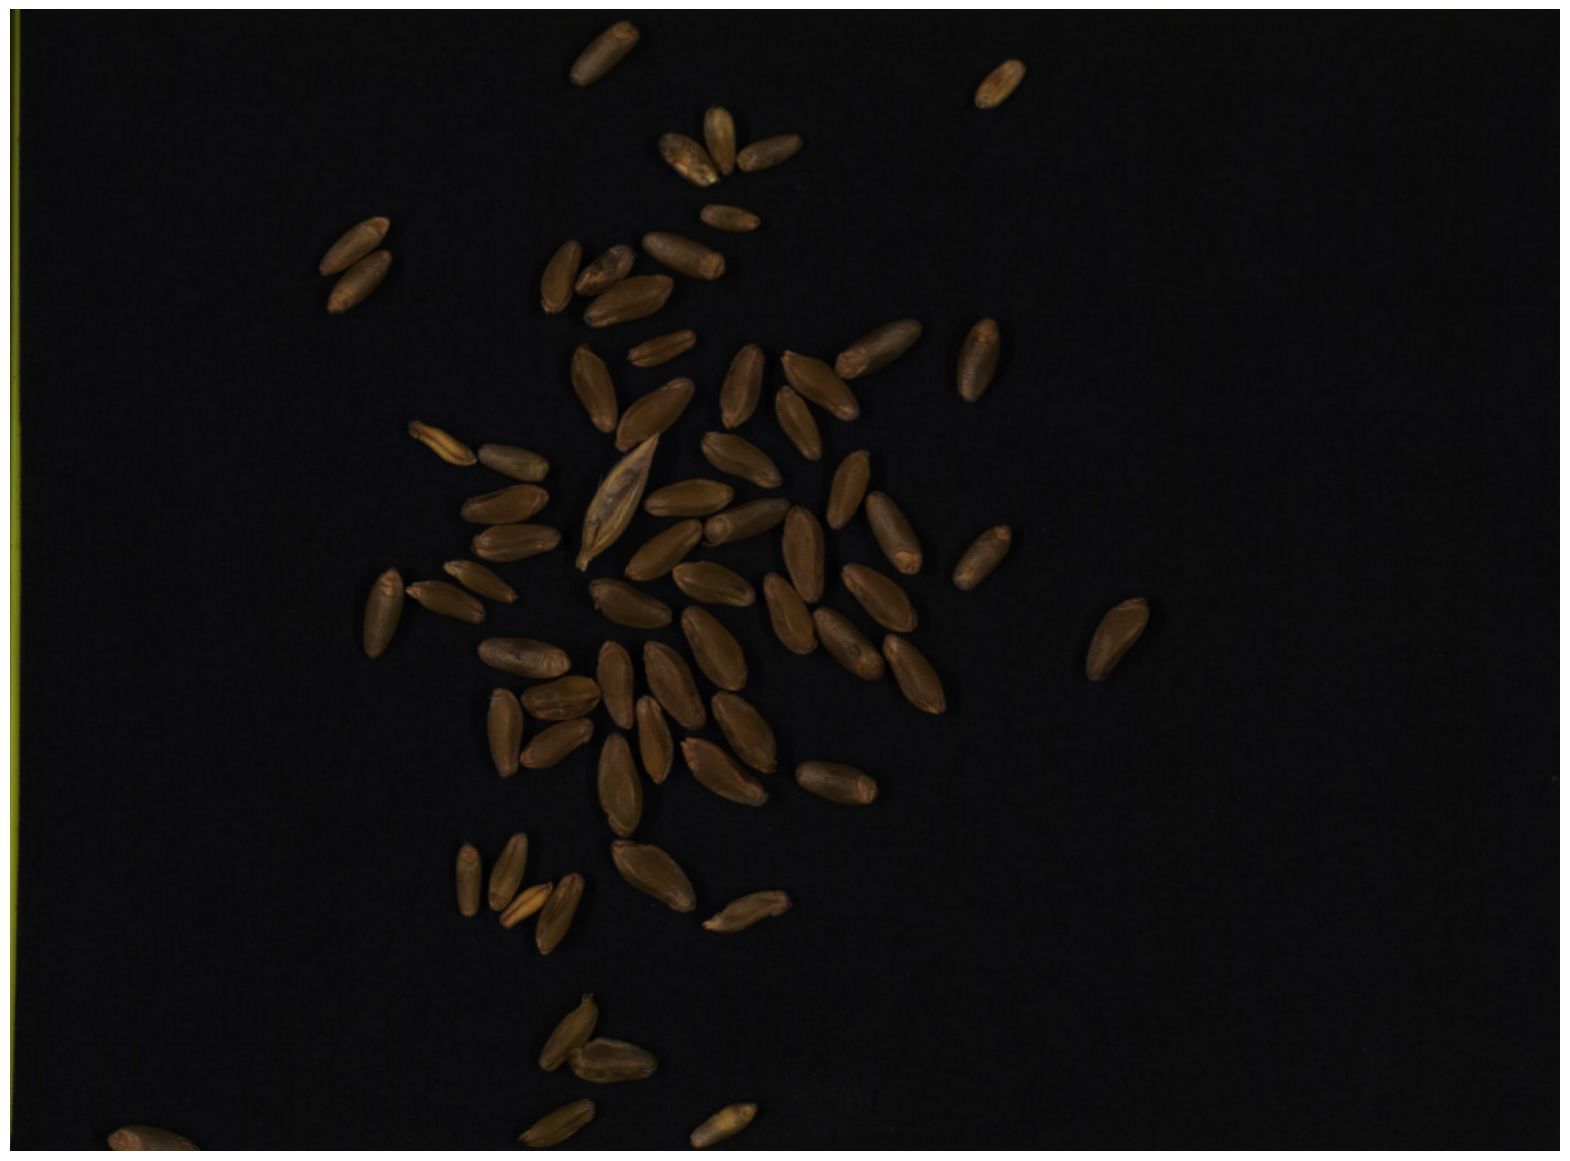

In [40]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
image = cv2.imread('/home/clement/projects/analyse_images/grains/images/grains_4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[:,690:3470]

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show() 

In [41]:
sam_checkpoint = "/home/clement/projects/analyse_images/grains/sam_b.pt"
model_type = "vit_b"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)


/home/clement/projects/analyse_images/grains/sam_env/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict

In [42]:
masks = mask_generator.generate(image)

In [43]:
print(len(masks))
print(masks[0].keys())

min_area = 4000
max_area = 15000

new_masks = []

for i in masks:
    if i['area'] > min_area and i['area'] < max_area:
        new_masks.append(i)


new_masks = sorted(new_masks, key=(lambda x: x['bbox']), reverse=True)


print("after filter")

print(len(new_masks))
print(new_masks[0].keys())

print(new_masks[0]["bbox"])

73
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
after filter
71
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[1929, 1055, 114, 149]


In [44]:
# def mask_center(mask):
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contour = max(contours, key=cv2.contourArea)
#     M = cv2.moments(contour)
#     cX = int(M["m10"] / M["m00"])
#     cY = int(M["m01"] / M["m00"])
#     return (cX,cY)

def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    n = 0
    for ann in anns:
        n+=1
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.45]])
        img[m] = color_mask
        
        bbox = ann['bbox']
        coord=( (bbox[0]*2+bbox[2]) / 2, (bbox[1]*2 + bbox[3]) / 2 )

        plt.text(x=int(coord[0]), y=int(coord[1]), s=str(n), fontsize=10, color= (1,1,1))

    ax.imshow(img)


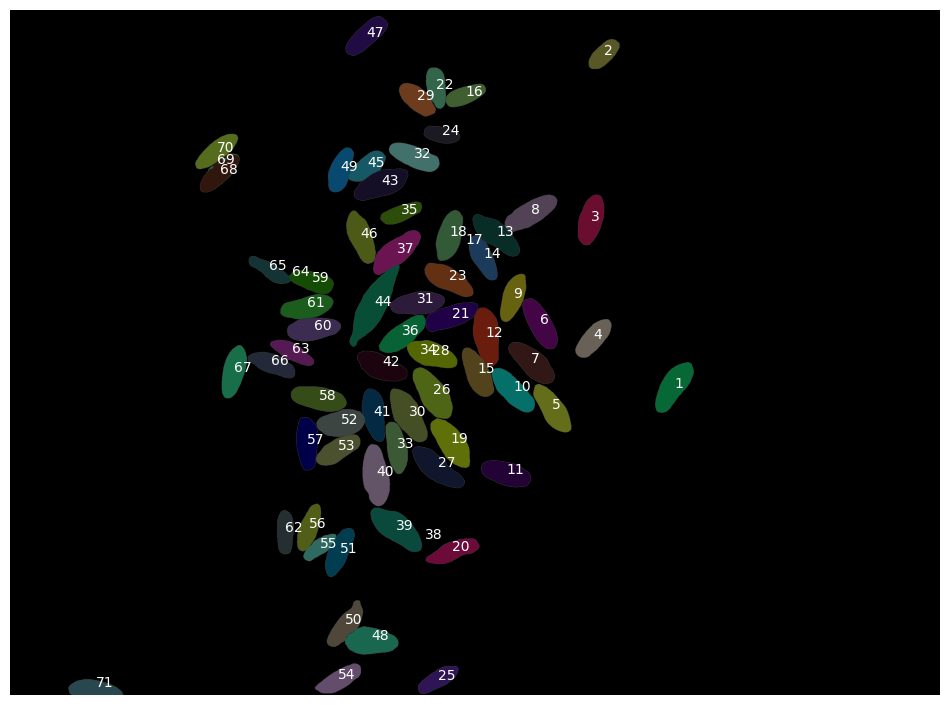

In [45]:

plt.figure(figsize=(12,16))
plt.imshow(np.zeros(image.shape))
show_anns(new_masks)
plt.axis('off')
plt.show()


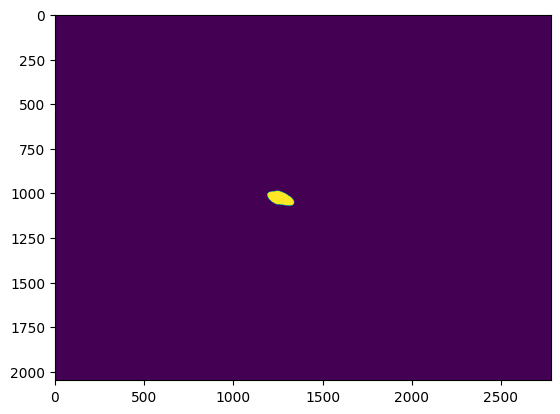

In [50]:

# plt.imshow(new_masks[15]["segmentation"])
plt.imshow(new_masks[27]["segmentation"])
# print(new_masks[36]["segmentation"].sum())

# m = new_masks[19]["segmentation"] != new_masks[36]["segmentation"] 

# print(m.sum())
# print(m.sum())


# m = new_masks[36]["segmentation"] / new_masks[19]["segmentation"]


# plt.figure(figsize=(12,16))
# plt.imshow(np.zeros(image.shape))
# show_anns(new_masks[12])
# plt.axis('off')
# plt.show() 

In [64]:
mask_generator2 = SamAutomaticMaskGenerator(
    model=sam,
    # points_per_side=40,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2
)

masks2 = mask_generator2.generate(image)



In [94]:
print(len(masks))
print(masks[0].keys())


min_area = 5000
max_area = 20000

new_masks2 = []

for i in masks2:
    if i['area'] > min_area and i['area'] < max_area:
        new_masks2.append(i)

print("after filter")

print(len(new_masks2))
print(new_masks2[0].keys())


53
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
after filter
51
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


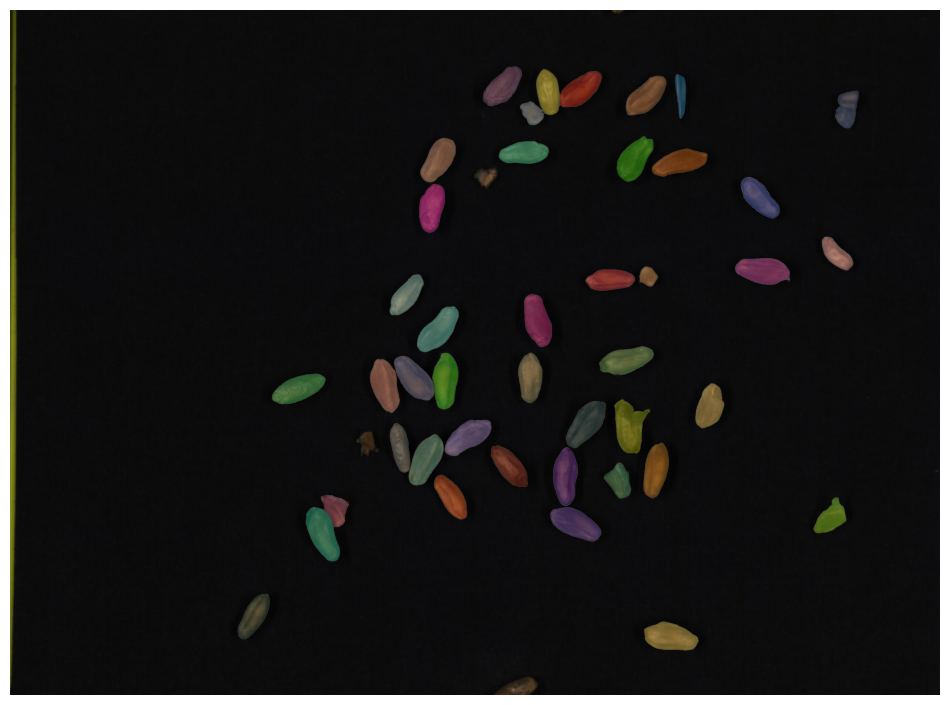

In [95]:
plt.figure(figsize=(12,16))
plt.imshow(image)
show_anns(new_masks2)
plt.axis('off')
plt.show() 

In [36]:
from pycocotools import mask as mask_utils
# cocomask = mask_utils.decode(masks[0]["segmentation"])
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 1395888,
 'bbox': [0, 0, 1368, 1297],
 'predicted_iou': 1.0323983430862427,
 'point_coords': [[1262.046875, 671.34375]],
 'stability_score': 0.9501948952674866,
 'crop_box': [0, 0, 1369, 1302]}